# Solving Optimization Problems with Multiple Adapters

OMMX Adapters have a standardized API, which allows us to solve the same problem using different solvers and compare the results. Let's first consider a simple knapsack problem as an example:

$$
\begin{align*}
\mathrm{maximize} \quad & \sum_{i=0}^{N-1} v_i x_i \\
\mathrm{s.t.} \quad & \sum_{i=0}^{n-1} w_i x_i - W \leq 0, \\
& x_{i} \in \{ 0, 1\} 
\end{align*}
$$


In [1]:
from ommx.v1 import Instance, DecisionVariable

v = [10, 13, 18, 31, 7, 15]
w = [11, 25, 20, 35, 10, 33]
W = 47
N = len(v)

x = [
    DecisionVariable.binary(
        id=i,
        name="x",
        subscripts=[i],
    )
    for i in range(N)
]
instance = Instance.from_components(
    decision_variables=x,
    objective=sum(v[i] * x[i] for i in range(N)),
    constraints=[sum(w[i] * x[i] for i in range(N)) - W <= 0],
    sense=Instance.MAXIMIZE,
)

## Solving the Problem with Multiple Solvers

Let's use the following open-source adapters that are developed alongside the OMMX SDK:

| Package name | PyPI | Backend |
|:--- |:--- |:--- |
| `ommx-python-mip-adapter` | [![ommx-python-mip-adapter](https://img.shields.io/pypi/v/ommx-python-mip-adapter)](https://pypi.org/project/ommx-python-mip-adapter/) | [CBC](https://github.com/coin-or/Cbc) via [Python-MIP](https://github.com/coin-or/python-mip) |
| `ommx-pyscipopt-adapter` | [![ommx-pyscipopt-adapter](https://img.shields.io/pypi/v/ommx-pyscipopt-adapter)](https://pypi.org/project/ommx-pyscipopt-adapter/) | [SCIP](https://github.com/scipopt/scip) via [PySCIPOpt](https://github.com/scipopt/PySCIPOpt) |
| `ommx-highs-adapter` | [![ommx-highs-adapter](https://img.shields.io/pypi/v/ommx-highs-adapter)](https://pypi.org/project/ommx-highs-adapter/) | [HiGHS](https://github.com/ERGO-Code/HiGHS) |

There are other adapters available as well:

TODO: Add amplify and gurobi adapters

In the following code, we'll use Gurobi, Highs, Python-MIP (CBC), and SCIP as solvers. Thanks to the standardized interface provided by the OMMX Solver Adapter implementation guide, we can write code like this:

In [2]:
from ommx_python_mip_adapter import OMMXPythonMIPAdapter
from ommx_pyscipopt_adapter  import OMMXPySCIPOptAdapter
from ommx_highs_adapter      import OMMXHighsAdapter

# List of adapters to use
adapters = {
    "highs": OMMXHighsAdapter,
    "cbc": OMMXPythonMIPAdapter,
    "scip": OMMXPySCIPOptAdapter,
}

# Solve the problem using each adapter
solutions = {
    name: adapter.solve(instance) for name, adapter in adapters.items()
}

## Comparing the Results

This knapsack problem is simple, so all solvers find the optimal solution.

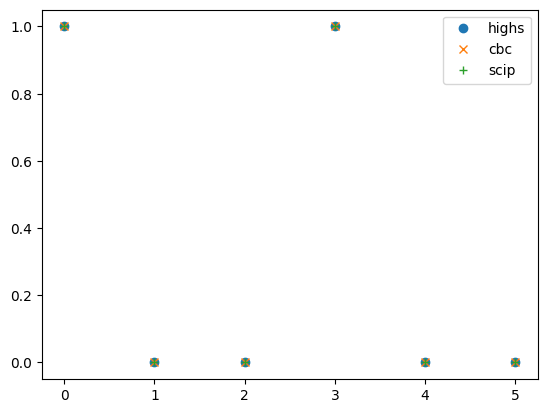

In [3]:
from matplotlib import pyplot as plt

marks = {
    "highs": "o",
    "cbc": "x",
    "scip": "+",
}

for name, solution in solutions.items():
    x = solution.extract_decision_variables("x")
    subscripts = [key[0] for key in x.keys()]
    plt.plot(subscripts, x.values(), marks[name], label=name)

plt.legend()

When analyzing results, it can be useful to combine the `decision_variables` DataFrames vertically.

In [4]:
import pandas

decision_variables = pandas.concat([
    solution.decision_variables.assign(solver=solver)
    for solver, solution in solutions.items()
])
decision_variables

,kind,lower,upper,name,subscripts,description,substituted_value,value,solver
id,,,,,,,,,
0,binary,0.0,1.0,x,[0],<NA>,<NA>,1.0,highs
1,binary,0.0,1.0,x,[1],<NA>,<NA>,0.0,highs
2,binary,0.0,1.0,x,[2],<NA>,<NA>,0.0,highs
3,binary,0.0,1.0,x,[3],<NA>,<NA>,1.0,highs
4,binary,0.0,1.0,x,[4],<NA>,<NA>,0.0,highs
5,binary,0.0,1.0,x,[5],<NA>,<NA>,0.0,highs
0,binary,0.0,1.0,x,[0],<NA>,<NA>,1.0,cbc
1,binary,0.0,1.0,x,[1],<NA>,<NA>,0.0,cbc
2,binary,0.0,1.0,x,[2],<NA>,<NA>,0.0,cbc
